## 正規化されたロジスティック回帰 (Regularized Logistic Regression)

あなたは、工場のプロダクトマネージャーです。
マイクロチップの２つのテスト結果から"Accept"か"Reject"を判断します。


Source: http://www.johnwittenauer.net/machine-learning-exercises-in-python-part-3/

流れ:
1. データをファイルから取得
2. シグモイド関数、コスト関数、Gradient Descentを定義
3. トレーニングを実施
4. 結果を評価、プロットする

In [2]:
# ライブラリ読み込み
import os
import numpy as np
import pandas as pd
import scipy.optimize as opt
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
# データを取得
path = '../data/ex2data2.txt'
data = pd.read_csv(path, header=None, names=['Test 1', 'Test 2', 'Accepted'])
data.head()

,Test 1,Test 2,Accepted
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


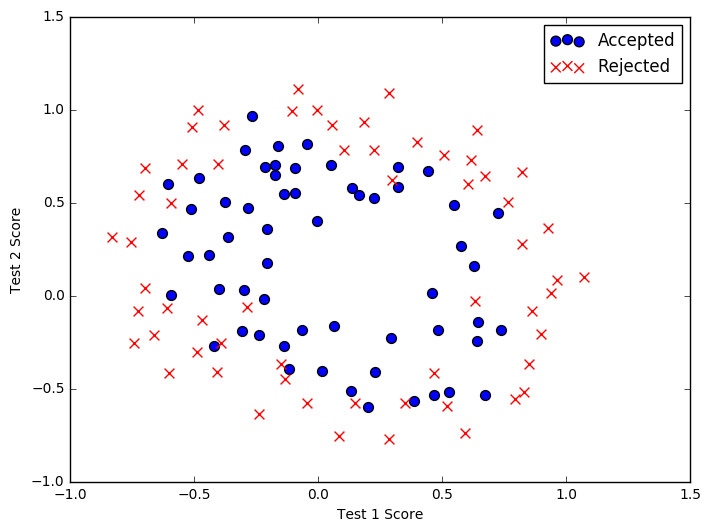

In [11]:
# データをプロット
positive = data[data['Accepted'].isin([1])]
negative = data[data['Accepted'].isin([0])]
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(positive['Test 1'], positive['Test 2'], s=50, c='b', marker='o', label='Accepted')
ax.scatter(negative['Test 1'], negative['Test 2'], s=50, c='r', marker='x', label='Rejected')
ax.legend()
ax.set_xlabel('Test 1 Score')
ax.set_ylabel('Test 2 Score')

In [12]:
# プロットすると線形で対応できなさそうなので多項にする
degree = 5
x1 = data['Test 1']
x2 = data['Test 2']

data.insert(3, 'Ones', 1)

for i in range(1, degree):
    for j in range(0, i):
        data['F' + str(i) + str(j)] = np.power(x1, i-j) * np.power(x2, j)

data.head()

,Test 1,Test 2,Accepted,Ones,F10,F20,F21,F30,F31,F32,F40,F41,F42,F43
0,0.051267,0.69956,1,1,0.051267,0.002628,0.035864,0.000135,0.001839,0.025089,0.000007,0.000094,0.001286,0.017551
1,-0.092742,0.68494,1,1,-0.092742,0.008601,-0.063523,-0.000798,0.005891,-0.043509,0.000074,-0.000546,0.004035,-0.029801
2,-0.213710,0.69225,1,1,-0.213710,0.045672,-0.147941,-0.009761,0.031616,-0.102412,0.002086,-0.006757,0.021886,-0.070895
3,-0.375000,0.50219,1,1,-0.375000,0.140625,-0.188321,-0.052734,0.070620,-0.094573,0.019775,-0.026483,0.035465,-0.047494
4,-0.513250,0.46564,1,1,-0.513250,0.263426,-0.238990,-0.135203,0.122661,-0.111283,0.069393,-0.062956,0.057116,-0.051818


In [13]:
# Test1, Test2列を削除
data.drop('Test 1', axis=1, inplace=True)
data.drop('Test 2', axis=1, inplace=True)
data.head()

,Accepted,Ones,F10,F20,F21,F30,F31,F32,F40,F41,F42,F43
0,1,1,0.051267,0.002628,0.035864,0.000135,0.001839,0.025089,0.000007,0.000094,0.001286,0.017551
1,1,1,-0.092742,0.008601,-0.063523,-0.000798,0.005891,-0.043509,0.000074,-0.000546,0.004035,-0.029801
2,1,1,-0.213710,0.045672,-0.147941,-0.009761,0.031616,-0.102412,0.002086,-0.006757,0.021886,-0.070895
3,1,1,-0.375000,0.140625,-0.188321,-0.052734,0.070620,-0.094573,0.019775,-0.026483,0.035465,-0.047494
4,1,1,-0.513250,0.263426,-0.238990,-0.135203,0.122661,-0.111283,0.069393,-0.062956,0.057116,-0.051818


In [14]:
# データを用意
cols = data.shape[1]
X = np.array(data.iloc[:, 1:cols].values)
y = np.array(data.iloc[:, 0:1].values)
theta = np.zeros(11)
learningRate = 1
X.shape, y.shape, theta.shape

((118, 11), (118, 1), (11,))

In [15]:
# シグモイド関数 g(z)
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [16]:
# 正規化項付きコスト関数
def costReg(theta, X, y, learningRate):
    theta = np.matrix(theta)
    x = np.matrix(X)
    y = np.matrix(y)
    m = len(X)
    first = np.multiply(-y, np.log(sigmoid(X * theta.T)))
    second = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))
    reg = (learningRate / 2 * m) * np.sum(np.power(theta[:, 1:theta.shape[1]], 2))
    return np.sum(first - second) / m + reg

In [17]:
# 正規化対応されたGradientDescent（1回実行）
def gradientReg(theta, X, y, learningRate):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    parameters = int(theta.ravel().shape[1])
    grad = np.zeros(parameters)
    error = sigmoid(X * theta.T) - y
    for i in range(parameters):
        term = np.multiply(error, X[:,i])
        if (i == 0):
            grad[i] = np.sum(term) / len(X)
        else:
            grad[i] = (np.sum(term) / len(X)) + ((learningRate / len(X)) * theta[:,i])
    return grad

In [18]:
# 予想関数
def predict(theta, X):
    probability = sigmoid(X * theta.T)
    return [1 if x >= 0.5 else 0 for x in probability]

In [19]:
# 関数計算
costReg(theta, X, y, learningRate)

0.6931471805599454

In [20]:
# GradientDescent実行
result = opt.fmin_tnc(func=costReg, x0=theta, fprime=gradientReg, args=(X, y, learningRate))
result

(array([  1.22702519e-04,   7.19894617e-05,  -3.74156201e-04,
         -1.44256427e-04,   2.93165088e-05,  -5.64160786e-05,
         -1.02826485e-04,  -2.83150432e-04,   6.47297947e-07,
         -1.99697568e-04,  -1.68479583e-05]), 96, 1)

In [21]:
# プロット
theta_min = np.matrix(result[0])
predictions = predict(theta_min, X)
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions, y)]
accuracy = (sum(map(int, correct)) % len(correct))
print('accuracy = {0}%'.format(accuracy))

accuracy = 77%
